# Supervised Fraud Detection using ETFD dataset from Kaggle
# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve

# Load Dataset

In [3]:
df = pd.read_csv('../data/ETFD_Dataset.txt', sep='\t')
df

,blockNumber,confirmations,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,19664511,201879,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,16217669,3648727,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,14351953,5514270,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,19753020,113094,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,19076055,790248,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84998,5950996,13816624,7,12,13,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
84999,5951042,13816578,7,12,13,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
85000,5951114,13816506,7,12,14,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
85001,5957365,13810255,7,13,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1


In [4]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')


Shape of Data: (85003, 15)

--- Class Balance (Fraud vs Normal) ---
Fraud
1    0.500029
0    0.499971
Name: proportion, dtype: float64


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_59212/2161099308.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')


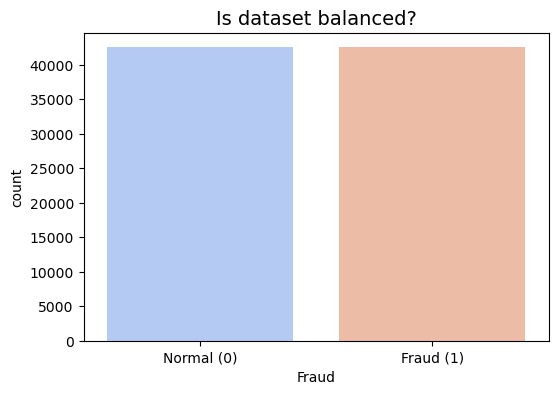


--- Top Features Correlated with Fraud ---
Fraud                                 1.000000
confirmations                         0.880294
total_tx_sent_malicious               0.218554
total_tx_sent_malicious_unique        0.209790
total_tx_received_malicious_unique    0.131387
Month                                 0.097111
Hour                                  0.062414
Day                                  -0.019343
variance_value_received              -0.115796
total_received                       -0.121746
Name: Fraud, dtype: float64
mean_value_received             -0.124467
total_tx_sent_unique            -0.205915
total_tx_sent                   -0.271143
time_diff_first_last_received   -0.376727
blockNumber                     -0.882195
Name: Fraud, dtype: float64


In [5]:
y = df['Fraud']
X = df.drop(columns=['Fraud'])
print(f"\nShape of Data: {df.shape}")

print("\n--- Class Balance (Fraud vs Normal) ---")
print(y.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='coolwarm')
plt.title("Is dataset balanced?", fontsize=14)
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

corr_matrix = df.select_dtypes(include=[np.number]).corr()
fraud_corr = corr_matrix['Fraud'].sort_values(ascending=False)

print("\n--- Top Features Correlated with Fraud ---")
print(fraud_corr.head(10))
print(fraud_corr.tail(5))

In [6]:
# dropping non-informative columns
df_train = df.drop(columns=['blockNumber', 'confirmations'])
df_train.head()

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0


In [7]:
# check for missing values
df_train.isnull().sum().sum()

0

In [8]:
df_train.columns

Index(['Month', 'Day', 'Hour', 'mean_value_received',
       'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')

In [9]:
df_train.describe()

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
count,85003.000000,85003.000000,85003.000000,85003.000000,8.500300e+04,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000
mean,6.058080,15.733951,12.138019,4.607558,4.079768e+03,3972.879905,304.783031,644.205369,49.362646,74.846217,12.049163,0.182076,0.500029
std,3.253529,8.736124,6.610912,31.713870,3.468387e+04,32287.360548,519.420096,1746.820366,215.433491,195.174043,51.611372,1.265924,0.500003
min,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,7.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,6.000000,16.000000,13.000000,0.000000,0.000000e+00,0.000000,0.000000,23.000000,0.000000,2.000000,0.000000,0.000000,1.000000
75%,9.000000,23.000000,18.000000,0.483130,3.821694e-01,22.876177,488.091528,437.000000,1.000000,45.000000,1.000000,0.000000,1.000000
max,12.000000,31.000000,23.000000,750.100000,1.124700e+06,281701.000000,2986.429039,9996.000000,1464.000000,1689.000000,293.000000,13.000000,1.000000


# Create train/validation/test split

In [10]:
X = df_train.drop(columns=['Fraud'])
y = df_train['Fraud']

# Separate out TRAIN set (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the remaining 30% into VALIDATION (15%) and TEST (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Baseline Models
## XGBoost

In [11]:
model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

print("Training Model")
model.fit(X_train, y_train)
print("Training Complete!")

# evaluate on VALIDATION set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

Training Model
Training Complete!


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Validation Performance ---
ROC-AUC Score: 0.9991

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6375
           1       0.99      0.99      0.99      6375

    accuracy                           0.99     12750
   macro avg       0.99      0.99      0.99     12750
weighted avg       0.99      0.99      0.99     12750

Confusion Matrix:
[[6294   81]
 [  65 6310]]


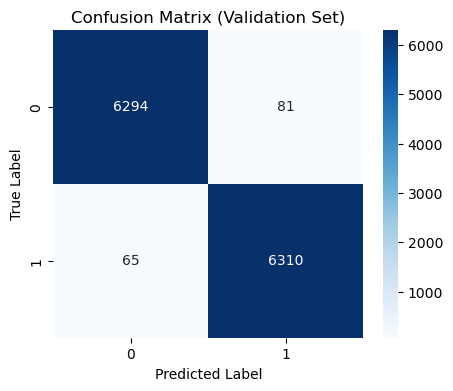

In [12]:
# metrics
print("\n--- Validation Performance ---")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

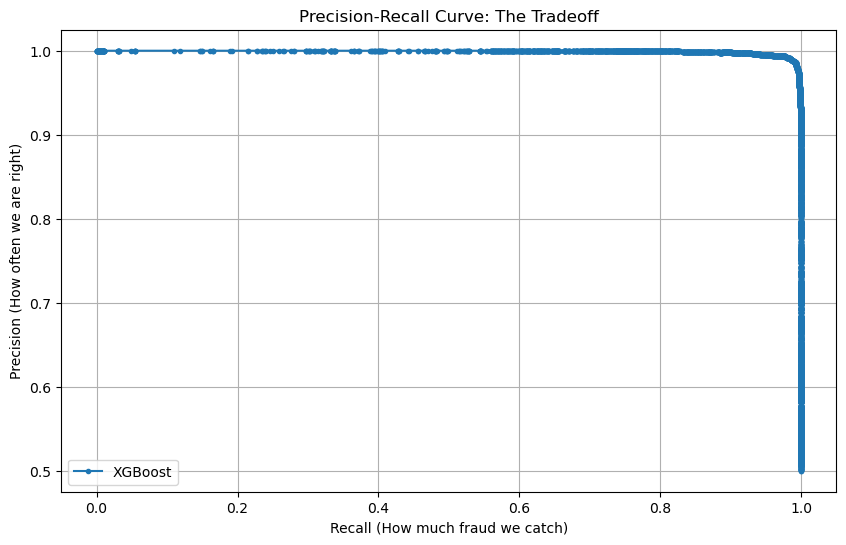

To achieve 0.9951 Precision (fewer false alerts):
We must accept a Recall of 0.9523 (catching slightly less fraud).
The threshold to set in our production engine is: 0.8725


In [13]:
# precision-recall curve
y_scores = model.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='.', label='XGBoost')
plt.xlabel('Recall (How much fraud we catch)')
plt.ylabel('Precision (How often we are right)')
plt.title('Precision-Recall Curve: The Tradeoff')
plt.grid(True)
plt.legend()
plt.show()

# say we want to minimize False Positives (High Precision)
# look for the threshold where Precision is at least 99.5%
desired_precision = 0.995
idx = np.where(precisions >= desired_precision)[0][0]

print(f"To achieve {precisions[idx]:.4f} Precision (fewer false alerts):")
print(f"We must accept a Recall of {recalls[idx]:.4f} (catching slightly less fraud).")
print(f"The threshold to set in our production engine is: {thresholds[idx]:.4f}")

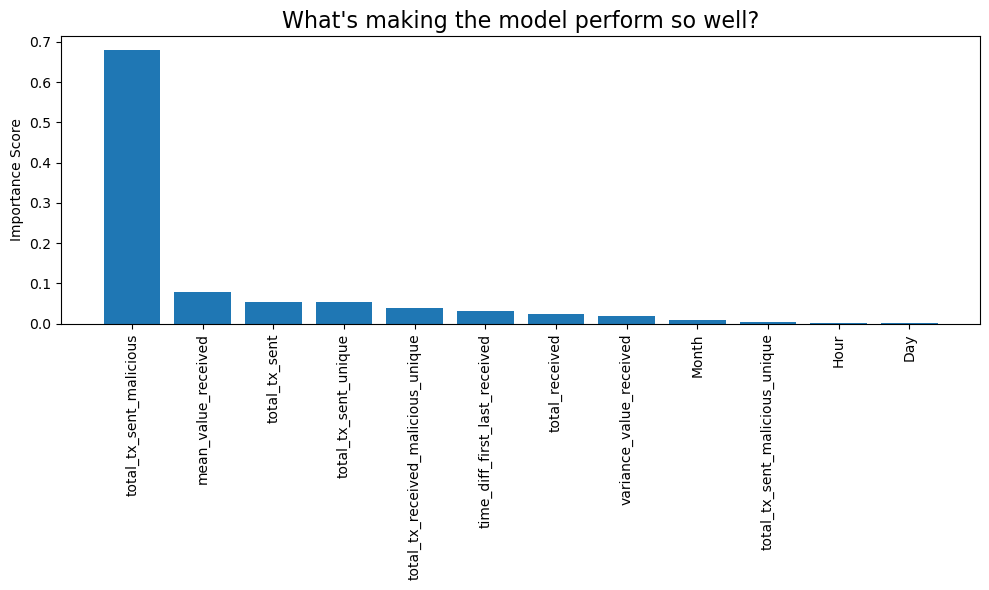

Top 5 Features Driving the Model:
1. total_tx_sent_malicious (0.6795)
2. mean_value_received (0.0784)
3. total_tx_sent (0.0549)
4. total_tx_sent_unique (0.0531)
5. total_tx_received_malicious_unique (0.0395)


In [14]:
# feature importance
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("What's making the model perform so well?", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

print("Top 5 Features Driving the Model:")
for i in range(5):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

## Logistic Regression

In [15]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("Training ...")
lr_pipeline.fit(X_train, y_train)

y_prob_lr = lr_pipeline.predict_proba(X_val)[:, 1]
roc_lr = roc_auc_score(y_val, y_prob_lr)

print(f"\nLogistic Regression ROC-AUC: {roc_lr:.4f}")
print(f"XGBoost ROC-AUC (Recall): {roc_auc_score(y_val, y_prob):.4f}")

Training ...

Logistic Regression ROC-AUC: 0.8879
XGBoost ROC-AUC (Recall): 0.9991


# XGBoost

In [35]:
def train_tuned_xgboost(X_train, y_train, X_val, y_val, model_name="XGBoost"):
    # 1. Define the model with "Reasonable Defaults" (Light Tuning)
    model = XGBClassifier(
        n_estimators=1000,      # High number, but Early Stopping will cut it short
        learning_rate=0.05,     # Lower rate = better generalization (slower learning)
        max_depth=4,            # Shallower trees = less overfitting (Default is 6)
        subsample=0.8,          # Use only 80% of data per tree (adds randomness)
        colsample_bytree=0.8,   # Use only 80% of features per tree
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        early_stopping_rounds=20 # STOP if no improvement for 20 rounds
    )
    
    print(f"--- Training {model_name} with Early Stopping ---")
    
    # 2. Fit with Eval Set (Monitors Overfitting)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False  # Turn to True if you want to see the logs
    )
    
    # Check how many trees it actually used
    print(f"Best Iteration: {model.best_iteration}")
    return model

In [36]:
def evaluate_fraud_model(model, X_val, y_val, threshold_target_recall=0.80):
    # 1. Get Probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # 2. ROC-AUC (Reference Metric)
    auc_score = roc_auc_score(y_val, y_prob)
    print(f"ROC-AUC Score: {auc_score:.4f}")
    
    # 3. Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    
    # 4. Find the Threshold for Target Recall (e.g., Catch 80% of Fraud)
    # We look for the index where Recall is closest to 0.80
    idx = np.argmin(np.abs(recalls - threshold_target_recall))
    best_threshold = thresholds[idx]
    current_precision = precisions[idx]
    
    print(f"\n--- Operating Point (Target Recall ~{threshold_target_recall*100}%) ---")
    print(f"Threshold: {best_threshold:.4f}")
    print(f"Precision: {current_precision:.4f} (When we flag, we are {current_precision*100:.1f}% correct)")
    print(f"Recall:    {recalls[idx]:.4f} (We catch {recalls[idx]*100:.1f}% of total fraud)")
    
    # 5. Business Impact (Confusion Matrix at this Threshold)
    y_pred_custom = (y_prob >= best_threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred_custom)
    
    tn, fp, fn, tp = cm.ravel()
    
    print("\n--- Business Impact Narrative ---")
    print(f"1. FRAUD CAUGHT: {tp} transactions blocked.")
    print(f"2. FALSE ALERTS: {fp} legitimate users annoyed.")
    print(f"3. MISSED FRAUD: {fn} criminals got away.")
    
    # The Narrative Sentence for your Portfolio
    print(f"\nPRODUCT NARRATIVE: \"At a threshold of {best_threshold:.2f}, we catch {tp} frauds. However, we incorrectly flag {fp} users.")
    if fp > 50:
        print("Recommendation: Since False Positives are high, use this as a STEP-UP trigger (2FA), not a hard block.\"")
    else:
        print("Recommendation: False Positives are low. We can confidently AUTO-BLOCK these transactions.\"")
        
    # Plot PR Curve
    plt.figure(figsize=(8, 5))
    plt.plot(recalls, precisions, marker='.', label='XGBoost Tuned')
    plt.scatter(recalls[idx], precisions[idx], color='red', label='Chosen Operating Point', zorder=5)
    plt.title(f'Precision-Recall Curve (AUC={auc_score:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return y_prob

--- Training Scenario A (Full) with Early Stopping ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [00:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best Iteration: 980

=== EVALUATION: SCENARIO A (Full Features) ===
ROC-AUC Score: 0.9993

--- Operating Point (Target Recall ~90.0%) ---
Threshold: 0.9750
Precision: 0.9977 (When we flag, we are 99.8% correct)
Recall:    0.9001 (We catch 90.0% of total fraud)

--- Business Impact Narrative ---
1. FRAUD CAUGHT: 5738 transactions blocked.
2. FALSE ALERTS: 13 legitimate users annoyed.
3. MISSED FRAUD: 637 criminals got away.

PRODUCT NARRATIVE: "At a threshold of 0.97, we catch 5738 frauds. However, we incorrectly flag 13 users.
Recommendation: False Positives are low. We can confidently AUTO-BLOCK these transactions."


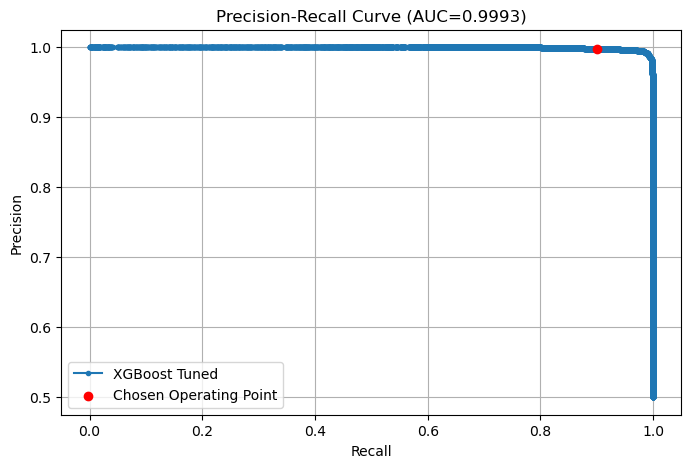

In [37]:
# A: Full Context
model_a_tuned = train_tuned_xgboost(X_train, y_train, X_val, y_val, model_name="Scenario A (Full)")
print("\n=== EVALUATION: SCENARIO A (Full Features) ===")
_ = evaluate_fraud_model(model_a_tuned, X_val, y_val, threshold_target_recall=0.90)

In [38]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')

--- Training Scenario B (Behavior) with Early Stopping ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [00:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best Iteration: 999

=== EVALUATION: SCENARIO B (Behavior Only) ===
ROC-AUC Score: 0.9799

--- Operating Point (Target Recall ~80.0%) ---
Threshold: 0.8115
Precision: 0.9668 (When we flag, we are 96.7% correct)
Recall:    0.8000 (We catch 80.0% of total fraud)

--- Business Impact Narrative ---
1. FRAUD CAUGHT: 5100 transactions blocked.
2. FALSE ALERTS: 175 legitimate users annoyed.
3. MISSED FRAUD: 1275 criminals got away.

PRODUCT NARRATIVE: "At a threshold of 0.81, we catch 5100 frauds. However, we incorrectly flag 175 users.
Recommendation: Since False Positives are high, use this as a STEP-UP trigger (2FA), not a hard block."


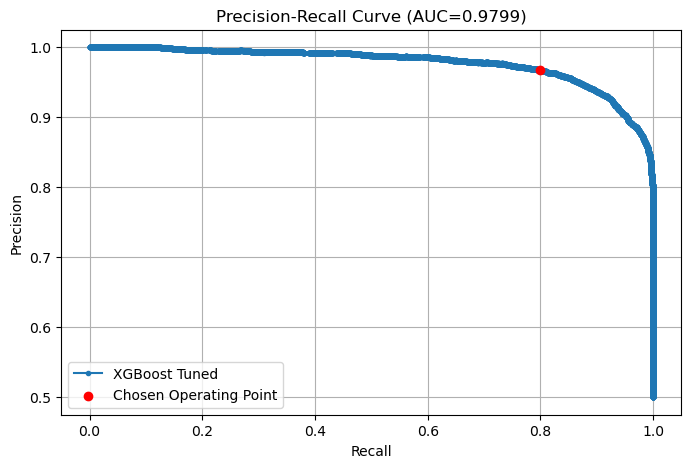

In [39]:
# B: Behavior Only (Drop Malicious Activity Features)
malicious_cols = ['total_tx_sent_malicious', 'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique']
X_train_beh = X_train.drop(columns=malicious_cols)
X_val_beh = X_val.drop(columns=malicious_cols)

model_b_tuned = train_tuned_xgboost(X_train_beh, y_train, X_val_beh, y_val, model_name="Scenario B (Behavior)")

print("\n=== EVALUATION: SCENARIO B (Behavior Only) ===")
_ = evaluate_fraud_model(model_b_tuned, X_val_beh, y_val, threshold_target_recall=0.80)

--- Visualizing Scenario B (Behavior Model) ---


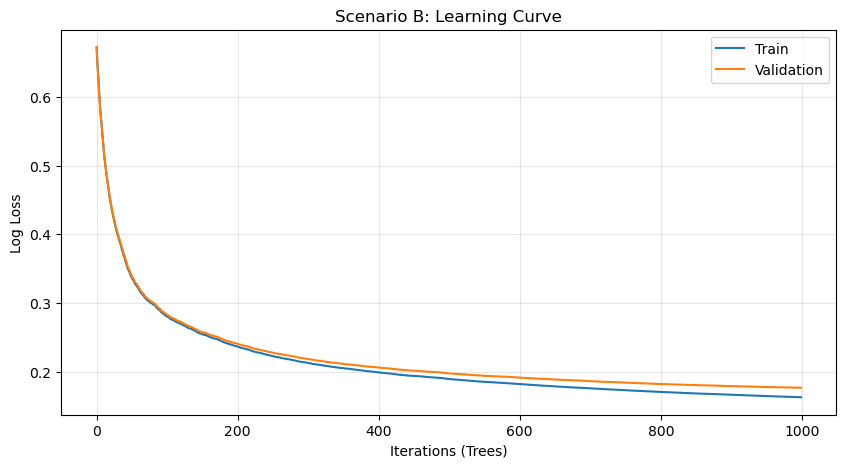

SUCCESS: Train and Validation track closely. Good generalization.


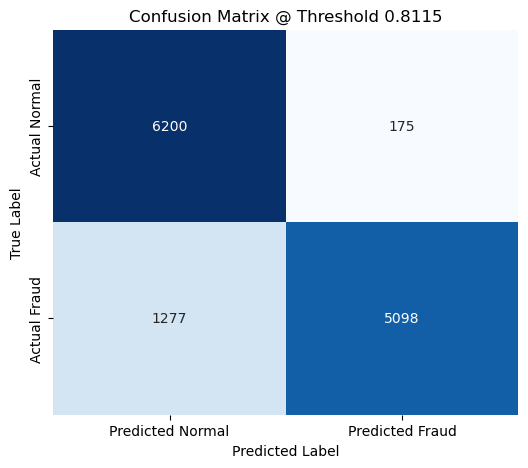

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. PLOT TRAINING VS VALIDATION LOSS (Learning Curves) ---
# This proves you monitored for Overfitting
def plot_learning_curves(model, model_name="XGBoost"):
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Iterations (Trees)')
    plt.title(f'{model_name}: Learning Curve')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Interpretation check
    if results['validation_1']['logloss'][-1] > results['validation_0']['logloss'][-1] + 0.1:
        print("WARNING: Gap between Train and Val suggests slight overfitting.")
    else:
        print("SUCCESS: Train and Validation track closely. Good generalization.")

# --- 2. PLOT CONFUSION MATRIX AT CUSTOM THRESHOLD ---
# Standard sklearn confusion_matrix uses 0.5. We need your 0.8115 threshold.
def plot_custom_confusion_matrix(model, X_val, y_val, threshold):
    # Get probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    # Convert to 0/1 using your custom threshold
    y_pred_custom = (y_prob >= threshold).astype(int)
    
    cm = confusion_matrix(y_val, y_pred_custom)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Normal', 'Predicted Fraud'],
                yticklabels=['Actual Normal', 'Actual Fraud'])
    plt.title(f'Confusion Matrix @ Threshold {threshold:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- EXECUTE VISUALIZATIONS FOR SCENARIO B ---
print("--- Visualizing Scenario B (Behavior Model) ---")

# 1. Learning Curves
plot_learning_curves(model_b_tuned, "Scenario B")

# 2. Confusion Matrix (Using the threshold you found: 0.8115)
plot_custom_confusion_matrix(model_b_tuned, X_val_beh, y_val, threshold=0.8115)

# RandomForest

# Prediction Descriptive Analysis

In [27]:
df_predictions = X_val.copy()
df_predictions["y_true"] = y_val
df_predictions["y_pred"] = pd.Series(y_pred, index=X_val.index)

df_predictions

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,y_true,y_pred
75121,10,1,4,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1
72273,3,6,14,0.000000,0.000000,0.000000,0.000000,4.0,4.0,3.0,3.0,0.0,1,1
77189,6,5,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1
67666,12,23,22,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1
84356,8,7,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84432,5,29,11,0.766892,0.065249,1.533785,4.838576,3.0,2.0,2.0,1.0,0.0,1,1
25657,4,21,13,0.001886,0.000000,0.001886,0.000000,1.0,0.0,1.0,0.0,0.0,0,0
81284,3,2,4,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1
46087,7,22,17,0.586097,0.227920,14.652437,13.547697,54.0,2.0,38.0,1.0,0.0,1,1


In [32]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')

In [ ]:
cols_to_check = ['mean_value_received', 'variance_value_received', 'total_received', 'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique', 'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique']

# df_predictions['label'] = np.where((df_predictions['y_true'] == 1) & (df_predictions['y_pred'] == 0), 'FN', 'TN')
# FN = df_predictions.query('y_true == 1 and y_pred == 0')
# FN[cols_to_check]
conditions = [
    (df_predictions['y_true'] == 1) & (df_predictions['y_pred'] == 1),  # TP
    (df_predictions['y_true'] == 0) & (df_predictions['y_pred'] == 0),  # TN
    (df_predictions['y_true'] == 1) & (df_predictions['y_pred'] == 0),  # FN
    (df_predictions['y_true'] == 0) & (df_predictions['y_pred'] == 1),  # FP
]

choices = ['TP', 'TN', 'FN', 'FP']

df_predictions['label'] = np.select(conditions, choices)

In [34]:
df_predictions

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,y_true,y_pred,label
75121,10,1,4,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1,TP
72273,3,6,14,0.000000,0.000000,0.000000,0.000000,4.0,4.0,3.0,3.0,0.0,1,1,TP
77189,6,5,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1,TP
67666,12,23,22,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1,TP
84356,8,7,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84432,5,29,11,0.766892,0.065249,1.533785,4.838576,3.0,2.0,2.0,1.0,0.0,1,1,TP
25657,4,21,13,0.001886,0.000000,0.001886,0.000000,1.0,0.0,1.0,0.0,0.0,0,0,TN
81284,3,2,4,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1,1,TP
46087,7,22,17,0.586097,0.227920,14.652437,13.547697,54.0,2.0,38.0,1.0,0.0,1,1,TP


In [ ]:
FP = df_predictions.query('y_true == 0 and y_pred == 1').shape

(81, 14)